In [48]:
%matplotlib inline
from gensim.models import Word2Vec
import sys
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn import tree
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

/home/simon/.local/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# load the model containing features
node2vecmodel = Word2Vec.load_word2vec_format("../big.bin" , binary=False)

In [63]:
X = []
Y = []

def handle_features(source, target):
    features_source = node2vecmodel[source]
    features_target = node2vecmodel[target]
    return features_source * features_target

# load all training pairs
i = 0
with open("trainingPairs_rust") as f:
    for line in f:
        source, target, label = tuple(line.split())
        if label == "1": continue
        if source in node2vecmodel and target in node2vecmodel:
            features = handle_features(source, target)
            #label = -1 if int(label) == 0 else 1
            label = int(label)
            Y.append(label)
            X.append(features)
        else:
            i += 1
            
# load positives from here
with open("trainingPairs.txt") as f:
    for line in f:
        source, target, label = tuple(line.split())
        if label == "0": continue
        if source in node2vecmodel and target in node2vecmodel:
            features = handle_features(source, target)
            #label = -1 if int(label) == 0 else 1
            label = int(label)
            Y.append(label)
            X.append(features)
        else:
            i += 1


print(len([x for x in Y if x == 0]))
print(len([x for x in Y if x == 1]))
print(i)
X = np.array(X)
Y = np.array(Y)

39679
79403
24224


In [6]:
model = SGDClassifier(loss="hinge", penalty="l2")
model.fit(X,Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [16]:
model.predict(handle_features("Jesus", "Gabriel"))

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([1])

In [35]:
X[0]

array([  5.01808063e-05,   5.58966394e-06,  -1.74713841e-05,
         1.42608958e-04,  -1.85299668e-05,  -6.68976718e-05,
         1.49306402e-06,  -2.24485571e-04,   7.31448454e-05,
         4.30349392e-05,  -1.58169587e-05,  -2.95010705e-05,
        -1.60777618e-05,   3.43087049e-05,  -2.83456011e-05,
         2.17078014e-05,   8.29275305e-05,  -2.52420985e-04,
         1.88621998e-05,   1.21838912e-05,  -5.20617141e-05,
        -4.38245988e-05,   2.28046410e-05,   1.72204076e-04,
         9.43936029e-05,  -5.68757278e-05,  -1.15217517e-05,
         1.15350376e-04,  -2.58629984e-06,  -1.08805179e-04,
        -1.77248876e-05,  -5.45173425e-05,  -2.52932805e-05,
        -2.26638091e-04,  -1.14771728e-05,  -8.54372047e-05,
         6.97579162e-06,   5.81959430e-05,   3.97224721e-05,
        -3.22274573e-05,   2.00094510e-05,  -5.62878158e-05,
         1.07850537e-05,   9.35170174e-05,  -5.17439958e-07,
         2.09943086e-04,  -2.37368313e-05,  -2.32820275e-05,
        -1.61187327e-05,

SGD: 0.891870 (0.001842)
Confusion matrix:
[[14529  5247]
 [ 3476 36289]]
Normalized confusion matrix
[[ 0.7346784   0.2653216 ]
 [ 0.08741355  0.91258645]]


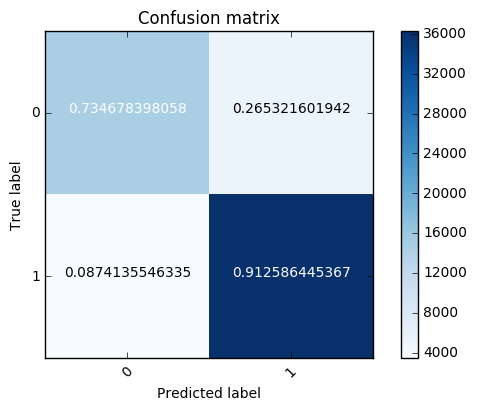

In [65]:
num_folds = 3
seed = 7
# prepare models
models = []
models.append(('SGD', SGDClassifier(loss="hinge", penalty="l2")))
# sanity check
#models.append(('Dummy', DummyClassifier("uniform")))
def keras_baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=128, init='normal', activation='relu'))
    model.add(Dense(1, init='normal', activation="relu"))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
#models.append(('Keras', KerasClassifier(build_fn=keras_baseline_model, nb_epoch=10, batch_size=128, verbose=0)))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=0)


# evaluate each model in turn
results = []
names = []
scoring = 'f1'
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X, y=Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    model.fit(X_train, y_train)
    y_true, y_pred = y_test, model.predict(X_test)
    #print("Classification report:")
    #print(classification_report(y_true, y_pred))
    
    print("Confusion matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    plot_confusion_matrix(cm, ["0", "1"], normalize=True) 
    

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')